This is a notebook that analyses the data from XCMS run in positive mode.

In [1]:
import pandas, numpy, seaborn, qnorm

In [2]:
import scipy, scipy.signal, scipy.stats

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':20
                           })

# user defined variable

In [4]:
input_data_file = '/home/adrian/projects/vigur/data/lipidomics/072/xcms/pos/PMVECs_EC72_Lipids_POS_29032022_withIS.csv'

# read information

In [5]:
df = pandas.read_csv(input_data_file)
df.shape

/tmp/ipykernel_284063/1072133223.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(input_data_file)


(22507, 223)

# manipulate information

In [6]:
# merge mz and RT as unique identifier
df.loc[:, 'unique_ID'] = df.loc[:, 'rt'].astype(str) + '_' + df.loc[:, 'mz'].astype(str)
df.set_index('unique_ID', inplace=True)
df.sort_index(inplace=True)

print(df.shape)
df.head()

(22507, 223)


,Unnamed: 0,mz,mzmin,mzmax,rt,rtmin,rtmax,rt(min),Internal Standard,LIPIDOMIX,...,EC72_Lipidomics_000210,EC72_Lipidomics_000211,EC72_Lipidomics_000212,EC72_Lipidomics_000213,EC72_Lipidomics_000214,EC72_Lipidomics_000215,EC72_Lipidomics_000216,isotopes,adduct,pcgroup
unique_ID,,,,,,,,,,,,,,,,,,,,,
100.182_313.2191795,4078,313.219179,313.213665,313.221599,100.182,97.190,105.976,1.669700,0,0,...,1499.464271,1596.832728,1721.638866,2364.582662,324.896726,2943.661044,276.581228,NaN,NaN,219
100.186_205.1947963,1931,205.194796,205.192206,205.197094,100.186,97.185,112.790,1.669767,0,0,...,324.320189,490.950726,276.207656,1177.067695,116.216646,1804.983562,112.533165,NaN,[M+K]+ 166.232 [M+Na]+ 182.206 [M+H]+ 204.188 ...,219
100.282_293.2459014,3627,293.245901,293.241772,293.248284,100.282,93.624,105.651,1.671367,0,0,...,829.775613,1040.545417,1051.947575,3076.865782,274.891832,4034.417035,256.762100,NaN,NaN,4477
100.415_663.4968406,13451,663.496841,663.487577,663.499662,100.415,97.189,105.976,1.673583,0,0,...,947.513880,1046.274579,1038.485702,1232.515987,49.803111,1146.301707,93.274746,[1564][M+3]+,NaN,219
100.456_643.4610967,12858,643.461097,643.447964,643.466081,100.456,96.217,105.651,1.674267,0,0,...,590.575463,613.970705,919.034624,1089.917966,126.446368,1020.589890,106.716415,NaN,[M+H]+ 642.458,219


In [7]:
# remove columns we are not interested
all_columns = df.columns
sampleIDs = [element for element in all_columns if 'EC72' in element]
sampleIDs.sort()

#metabolites = df[df['Internal Standard'] == 0].index

intensities = df.loc[:, sampleIDs]
log10intensities = numpy.log10(intensities + 1)
print(intensities.shape)
intensities.head()

(22507, 204)


,EC72_Lipidomics_000094,EC72_Lipidomics_000095,EC72_Lipidomics_000096,EC72_Lipidomics_000097,EC72_Lipidomics_000098,EC72_Lipidomics_000099,EC72_Lipidomics_000100,EC72_Lipidomics_000101,EC72_Lipidomics_000102,EC72_Lipidomics_000103,...,EC72_Lipidomics_000399,EC72_Lipidomics_000400,EC72_Lipidomics_000401,EC72_Lipidomics_000402,EC72_Lipidomics_000403,EC72_Lipidomics_000404,EC72_Lipidomics_000405,EC72_Lipidomics_000406,EC72_Lipidomics_000407,EC72_Lipidomics_000408
unique_ID,,,,,,,,,,,,,,,,,,,,,
100.182_313.2191795,310.223318,2257.249739,287.889292,355.828467,1338.376292,2087.349316,2277.039129,1808.190554,403.096791,2490.814459,...,1983.381433,173.750701,1508.511753,3850.325239,1501.470442,5105.200536,3596.402594,228.180144,12440.079330,451.800512
100.186_205.1947963,111.285308,1113.259198,71.256232,115.679709,244.668270,319.990671,977.434449,369.903027,136.886727,398.656730,...,1009.599888,105.996201,353.975119,2936.950785,255.778428,554.414236,673.026376,96.907845,4229.413274,142.985281
100.282_293.2459014,297.117369,2880.618714,338.197566,317.673778,694.458974,976.297940,2058.805285,1121.778555,398.569077,1340.558873,...,2374.839662,135.951987,1268.576850,6738.615034,872.068020,1300.816799,1646.775447,183.849727,4238.627893,306.260020
100.415_663.4968406,83.701968,844.810923,74.089691,54.462371,863.175026,753.548581,1112.240190,1026.563255,77.469727,2067.740248,...,778.508681,84.605905,336.110008,965.564073,675.069667,615.567344,852.504465,74.387953,5574.496490,150.168693
100.456_643.4610967,166.831709,923.339484,103.268595,157.463079,868.301787,632.797645,1117.113839,757.224454,153.999440,1899.051149,...,722.506543,111.745040,418.955595,1062.399094,534.980754,480.274444,502.812973,97.524210,5735.809080,194.268781


We have 22,501 features.

In [8]:
# get the internal standards
metabolites = df[df['Internal Standard'] != 0].index

iss = df.loc[metabolites, sampleIDs]
log10iss = numpy.log10(iss)
print(iss.shape)
iss.head()

(6, 204)


,EC72_Lipidomics_000094,EC72_Lipidomics_000095,EC72_Lipidomics_000096,EC72_Lipidomics_000097,EC72_Lipidomics_000098,EC72_Lipidomics_000099,EC72_Lipidomics_000100,EC72_Lipidomics_000101,EC72_Lipidomics_000102,EC72_Lipidomics_000103,...,EC72_Lipidomics_000399,EC72_Lipidomics_000400,EC72_Lipidomics_000401,EC72_Lipidomics_000402,EC72_Lipidomics_000403,EC72_Lipidomics_000404,EC72_Lipidomics_000405,EC72_Lipidomics_000406,EC72_Lipidomics_000407,EC72_Lipidomics_000408
unique_ID,,,,,,,,,,,,,,,,,,,,,
241.185_538.3888529,217.282744,76514.390040,323.547011,300602.8647,88762.743900,39289.640530,9.065971e+04,87466.904250,134869.129200,345147.143900,...,43052.865360,79.675241,95222.129170,96452.018180,89170.320780,53272.67992,94645.947770,131.681540,750054.54210,106.746630
384.765_717.5927542,233.457858,39247.460260,148.186390,125944.9610,50466.589740,15611.303660,5.192404e+04,44077.406170,85284.663680,48594.766460,...,39153.179280,48.343421,61451.790840,62930.942650,56574.178420,51851.68541,38879.109910,193.274214,382264.28160,223.101801
385.637_720.5614759,421.514001,2970.737877,217.925948,13330.8530,7480.968302,1987.843376,5.937749e+03,4616.101386,7674.339684,4090.646401,...,3017.887872,59.102817,6113.564876,2655.562312,4793.770796,3216.18077,1945.867688,249.107647,28626.71574,247.119033
427.528_762.603288,422.134232,523269.793000,372.993076,454806.9908,201758.765600,79755.244540,1.285698e+06,248353.930100,365786.516500,249174.864900,...,106957.397100,180.977148,296631.992200,187554.449300,313205.366100,182177.92740,218065.766300,1991.620384,725890.34650,1853.702651
473.383_818.666092,209.785749,80982.488530,255.532690,170406.1652,48724.830050,28189.327030,1.096009e+05,59325.050040,132821.439100,60933.916130,...,35092.620090,79.314497,63008.280920,30533.991670,89059.888530,28803.25540,45214.067150,838.877193,164412.23480,432.744815


# visualize information

## histogram across retention time

15.916716666666668
0.09758333333333334


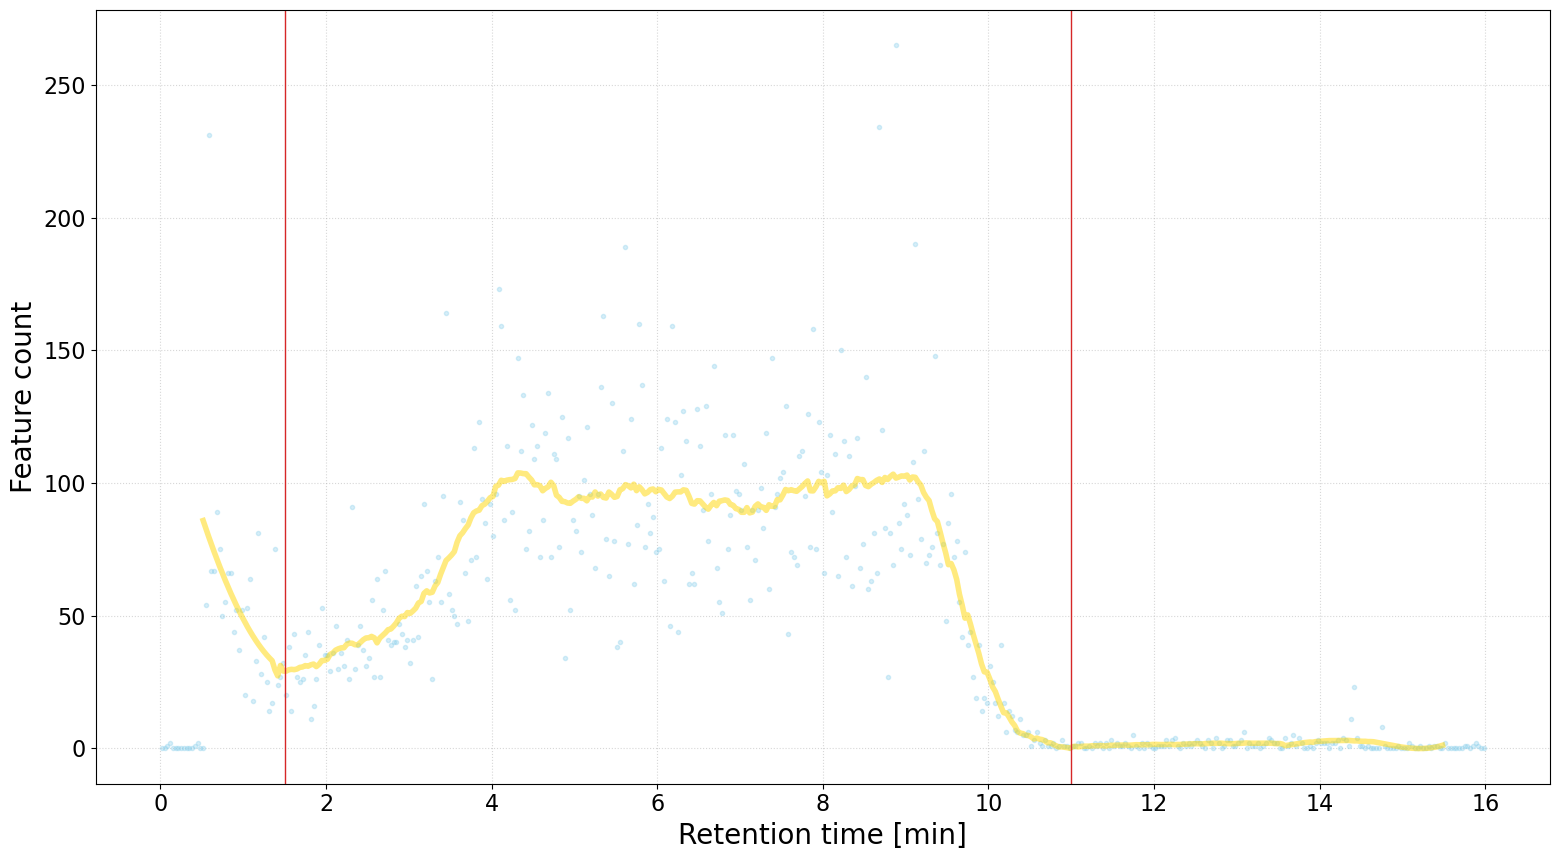

In [9]:
values = df['rt']/60

print(numpy.max(values))
print(numpy.min(values))

found_min = 0 
found_max = 16
number_of_bins = found_max*30

hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(found_min, found_max))
half_bin = (bin_edges[1] - bin_edges[0])/2
x = bin_edges + half_bin
x = x[:-1]

matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color='skyblue')

margin = 15
plotting_x = x[margin:number_of_bins-margin]
plotting_hist = hist[margin:number_of_bins-margin]

yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color='gold')
      
#matplotlib.pyplot.xlim([10.5, 23.5])
#matplotlib.pyplot.ylim([-0.5, 9])

matplotlib.pyplot.xlabel('Retention time [min]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.axvline(x=1.5, lw=1, color='tab:red')
matplotlib.pyplot.axvline(x=11, lw=1, color='tab:red')


matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Should we consider excluding some features?

## visualize internal standards

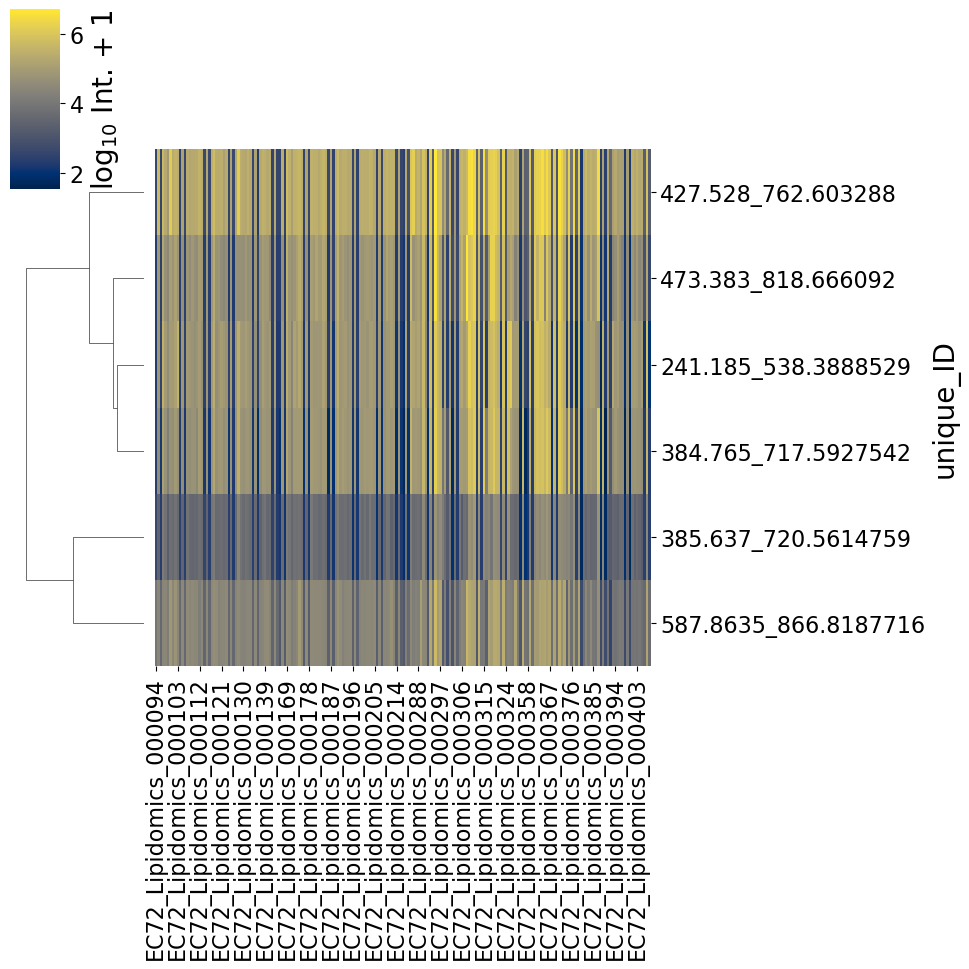

In [10]:
seaborn.clustermap(log10iss, row_cluster=True, col_cluster=False, cmap='cividis', 
                    method='ward', metric='euclidean', 
                    cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                    )
matplotlib.pyplot.show()

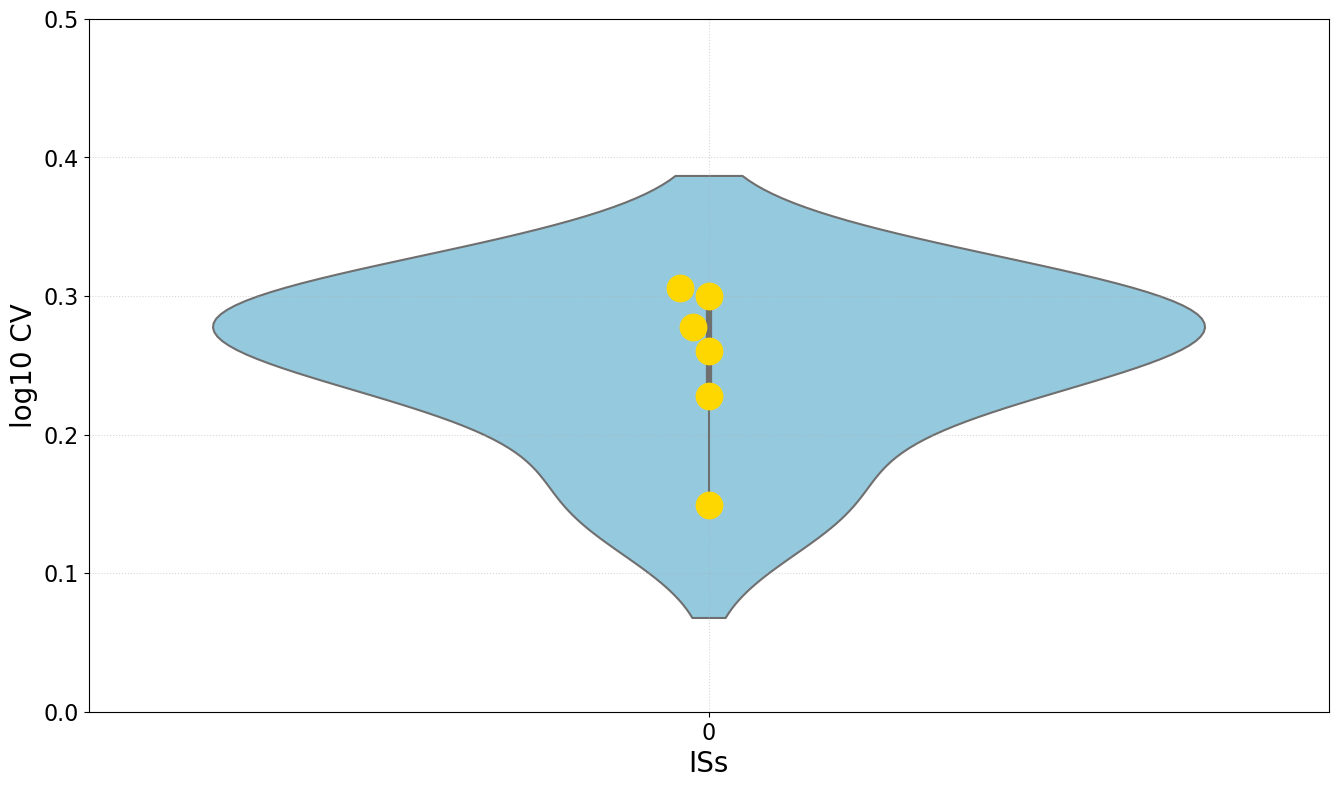

In [11]:
m = log10iss.mean(axis=1)
s = log10iss.std(axis=1)
cv = s/m

seaborn.violinplot(cv, color='skyblue')
seaborn.swarmplot(cv, color='gold', size=20)

matplotlib.pyplot.ylim(0, 0.5)
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.xlabel('ISs')
matplotlib.pyplot.ylabel('log10 CV')
matplotlib.pyplot.show()

In [12]:
# CV in log scaled data https://en.wikipedia.org/wiki/Coefficient_of_variation

#cv = 

## visualize samples

In [13]:
#intensities.columns.to_list()

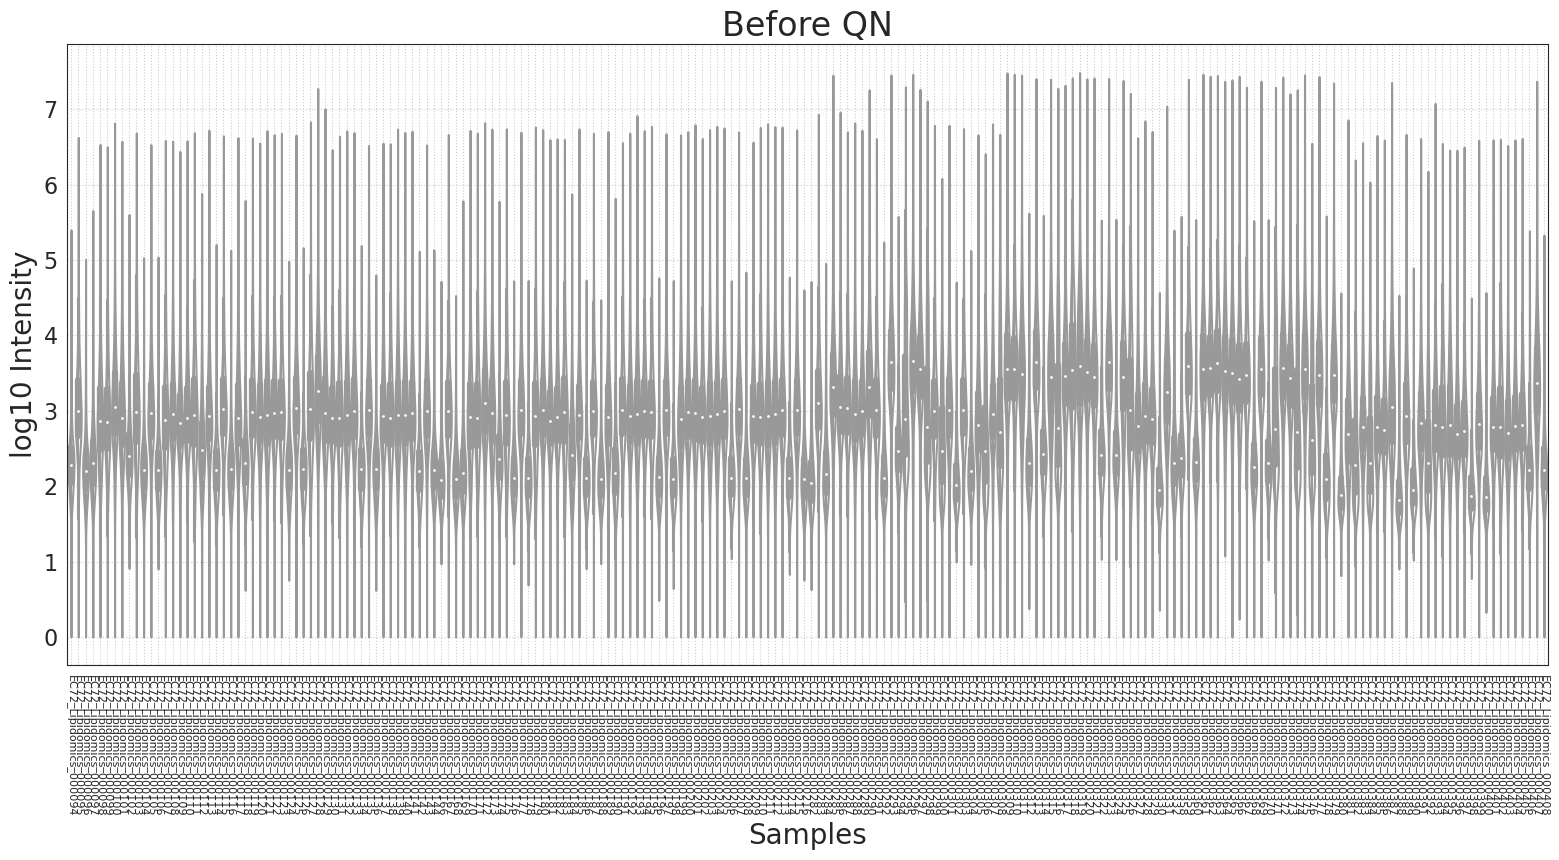

In [14]:
seaborn.set_style("white")
g = seaborn.violinplot(data=log10intensities, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='Before QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# quantile normalization

In [15]:
###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10intensities.values, axis=0), 
                             index=log10intensities.index, 
                             columns=log10intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

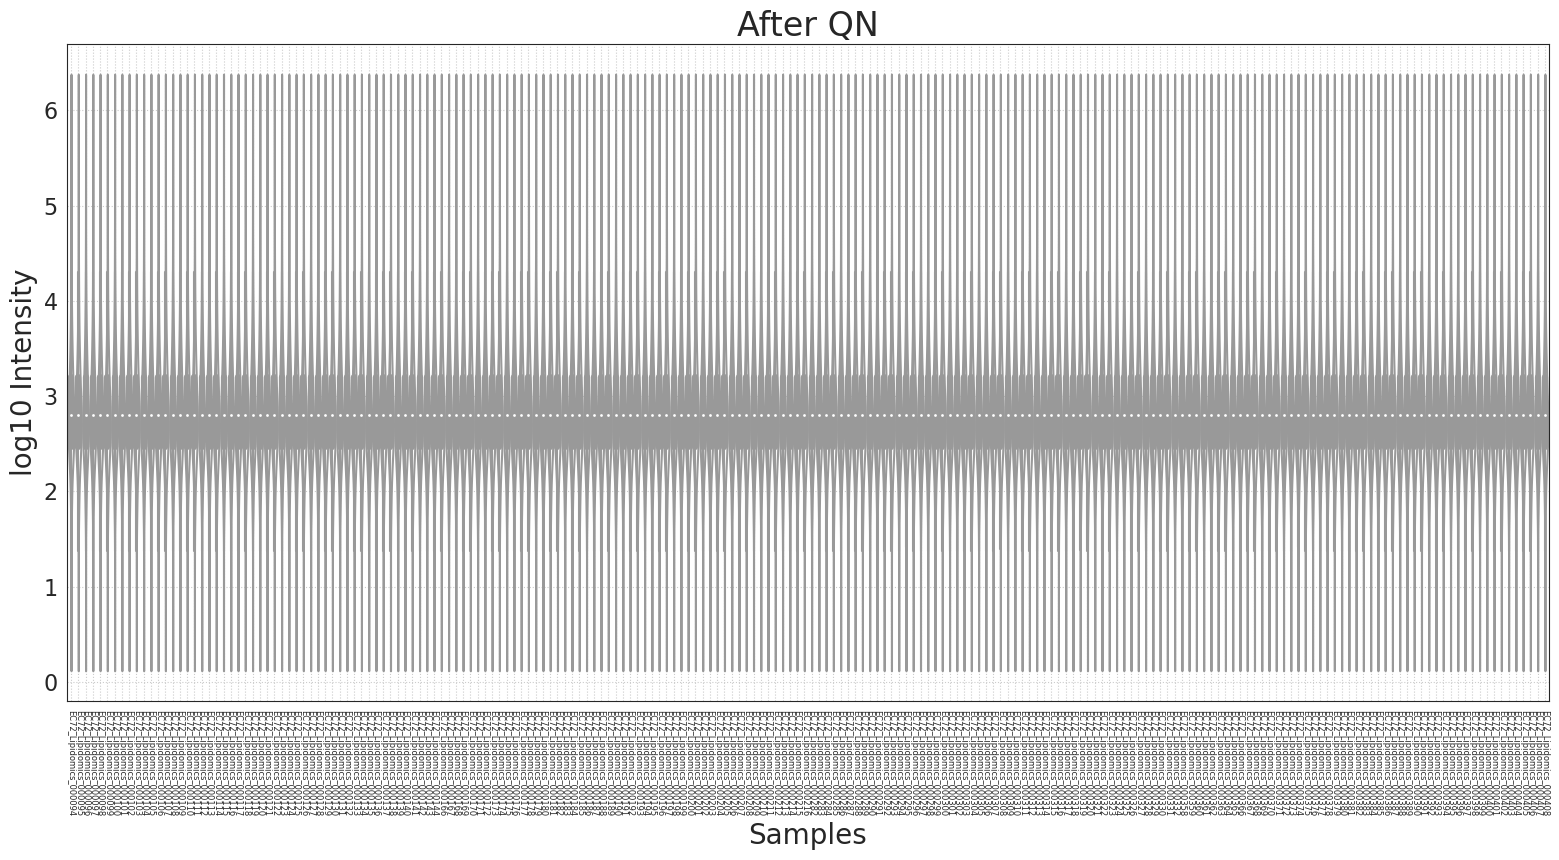

In [16]:
g = seaborn.violinplot(data=df_qn, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [17]:
mqndf = qnorm.quantile_normalize(log10intensities, axis=1)

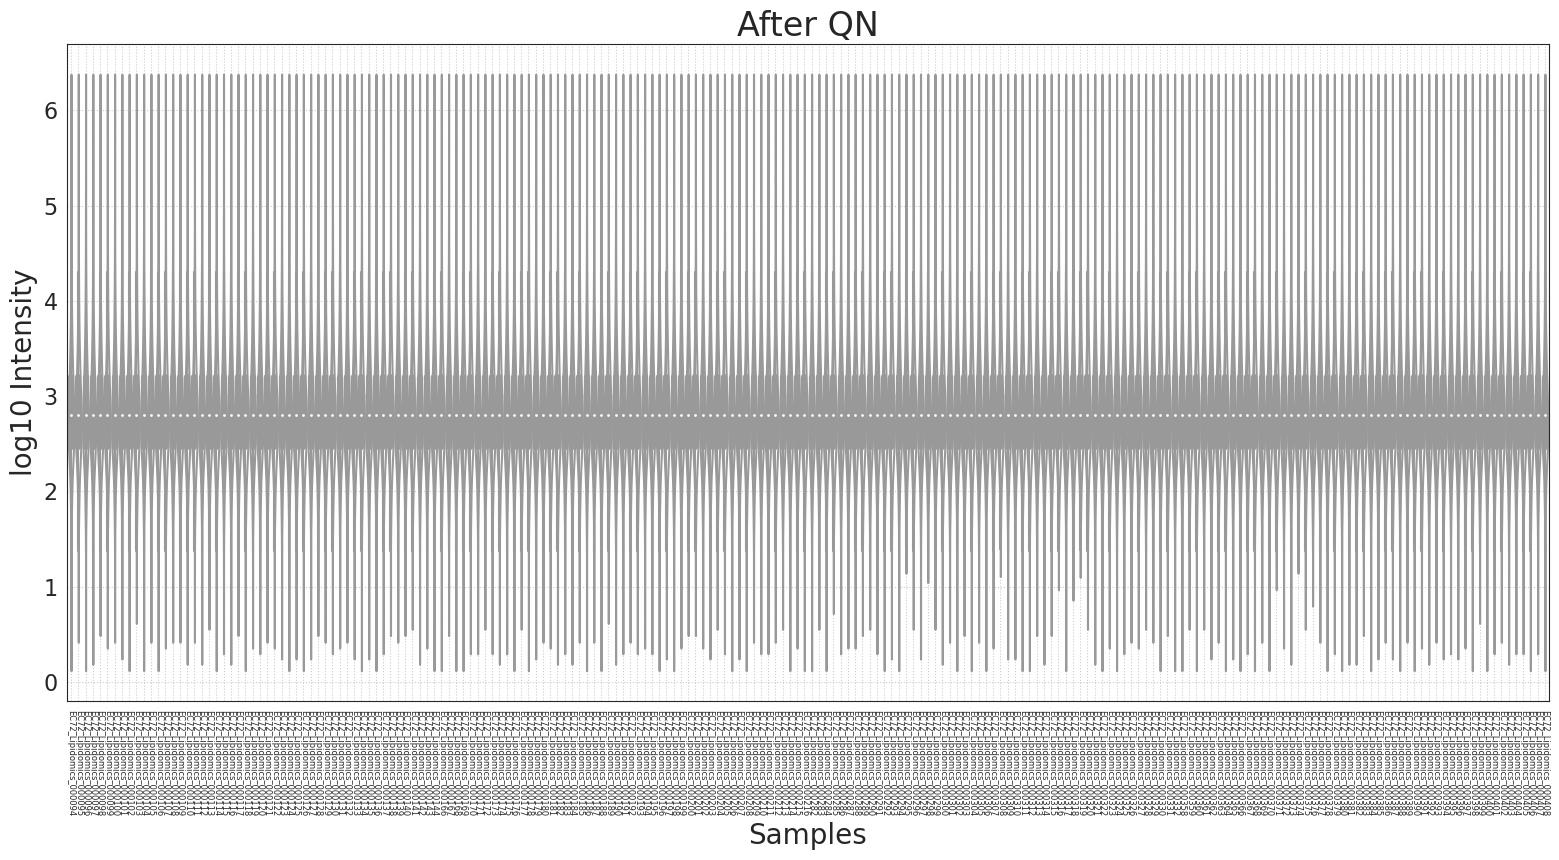

In [18]:
g = seaborn.violinplot(data=mqndf, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()